# Transfer Learning CIFAR10

* Train a simple convnet on the CIFAR dataset the first 5 output classes [0..4].
* Freeze convolutional layers and fine-tune dense layers for the last 5 ouput classes [5..9].


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [3]:
import numpy as np
np.random.seed(42)

In [4]:
import  tensorflow as tf
tf.reset_default_graph()
tf.set_random_seed(42)

In [5]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [6]:
tf.keras.__version__
tf.__version__

'2.2.4-tf'

'1.14.0'

In [7]:
# Initialize the random number generator
import random
random.seed(0)

import warnings
warnings.filterwarnings("ignore")

### 1. Import CIFAR10 data and create 2 datasets with one dataset having classes from 0 to 4 and other having classes from 5 to 9 

In [8]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
%matplotlib inline
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images.shape
train_labels.shape
test_images.shape
test_labels.shape
train_images.dtype
train_labels.dtype

(50000, 32, 32, 3)

(50000, 1)

(10000, 32, 32, 3)

(10000, 1)

dtype('uint8')

dtype('uint8')

In [9]:
cifar10_labels = [ "airplane",  # index 0
                   "automobile",   # index 1
                   "bird",   # index 2 
                   "cat",   # index 3 
                   "deer",    # index 4
                   "dog",    # index 5
                   "frog",     # index 6 
                   "horse",   # index 7 
                   "ship",   # index 8 
                   "truck"]   # index 9

In [10]:
def plot_images(image_label_tuple, grid_nums):
    plt.figure(figsize=(2*grid_nums, 2*grid_nums))
    for i in range(grid_nums**2):
        plt.subplot(grid_nums, grid_nums, i+1)
        plt.imshow(image_label_tuple[0][i], cmap='gray')
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(cifar10_labels[image_label_tuple[1][i][0]])
        plt.grid(False)
    plt.show()    

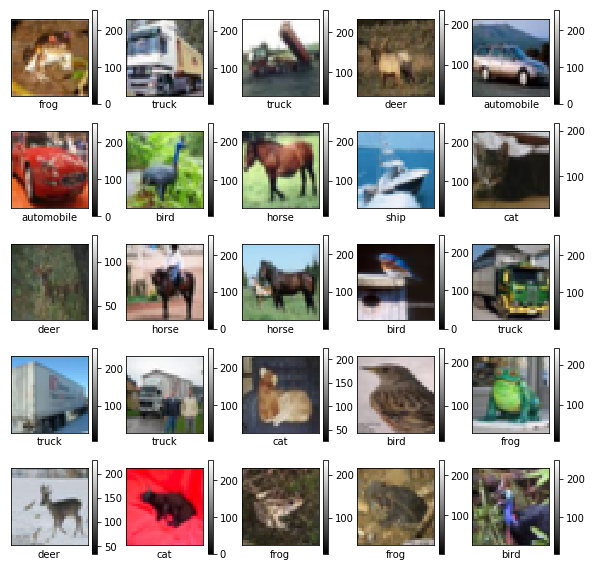

In [11]:
plot_images((train_images, train_labels),5)

In [12]:
train_images_0_4 = np.array([train_images[i] for i, x in enumerate(train_labels.tolist()) if x[0] < 5])
test_images_0_4 = np.array([test_images[i] for i, x in enumerate(test_labels.tolist()) if x[0] < 5])
train_labels_0_4 = np.array([train_labels[i] for i, x in enumerate(train_labels.tolist()) if x[0] < 5])
test_labels_0_4 = np.array([test_labels[i] for i, x in enumerate(test_labels.tolist()) if x[0] < 5])

In [13]:
train_images_5_9 = np.array([train_images[i] for i, x in enumerate(train_labels.tolist()) if x[0] >= 5])
test_images_5_9 = np.array([test_images[i] for i, x in enumerate(test_labels.tolist()) if x[0] >= 5])
train_labels_5_9 = np.array([train_labels[i] for i, x in enumerate(train_labels.tolist()) if x[0] >= 5])
test_labels_5_9 = np.array([test_labels[i] for i, x in enumerate(test_labels.tolist()) if x[0] >= 5])

In [14]:
train_images_0_4.shape
test_images_0_4.shape

(25000, 32, 32, 3)

(5000, 32, 32, 3)

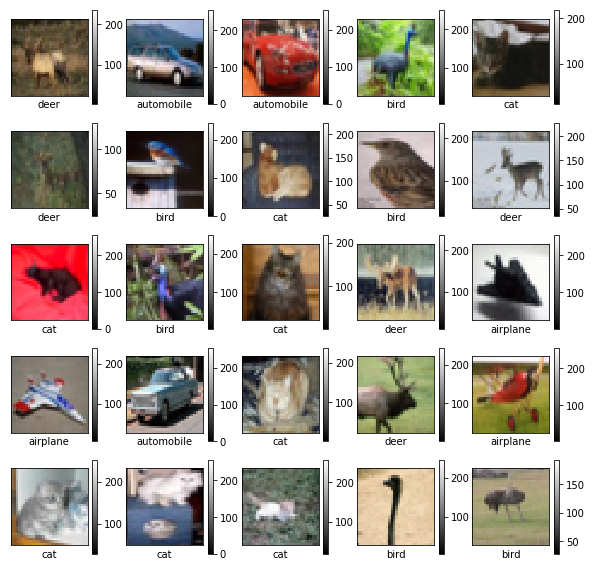

In [15]:
plot_images((train_images_0_4, train_labels_0_4),5) #Excluding truck, ship, horse, frog, dog

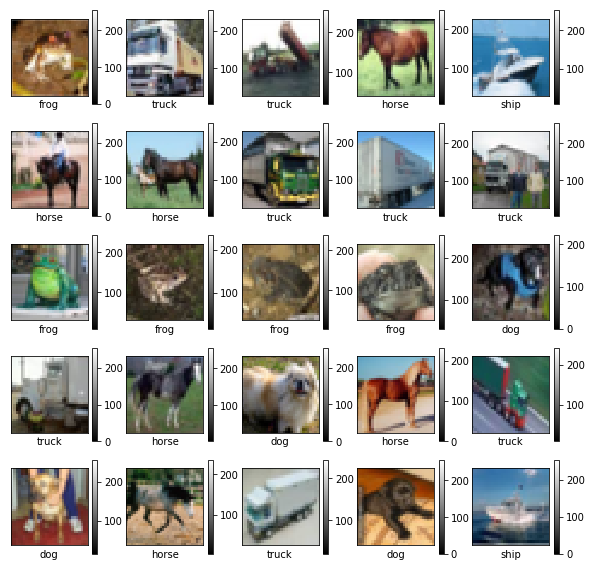

In [16]:
plot_images((train_images_5_9, train_labels_5_9),5) #Including only truck, ship, horse, frog, dog

In [17]:
train_images_0_4.shape
train_labels_0_4.shape
test_images_0_4.shape
test_labels_0_4.shape
train_images_5_9.shape
train_labels_5_9.shape
test_images_5_9.shape
test_labels_5_9.shape

(25000, 32, 32, 3)

(25000, 1)

(5000, 32, 32, 3)

(5000, 1)

(25000, 32, 32, 3)

(25000, 1)

(5000, 32, 32, 3)

(5000, 1)

### Using the reshape and Normalization as layer functions below for 3 & 4 below

In [18]:
tf.keras.backend.clear_session()
# Initialize model, reshape & normalize the data
model = tf.keras.models.Sequential()

### Reshape data
- reshape first dataset
- To be able to use the dataset in Keras, we need 4-dims numpy arrays. 
- reshape features to pass it to a Conv2D layer
- channel = 1
- reshape features of first dataset only
- do not reshape labels

In [19]:
# Reshape the data from  (32,32,3) to (32,32, 3)
model.add(tf.keras.layers.Reshape(target_shape=(32,32,3), input_shape=(32,32,3)))

### Normalize data
- normalize first dataset
- we must normalize our data as it is always required in neural network models
- we can achieve this by dividing the RGB codes to 255 (which is the maximum RGB code minus the minimum RGB code)
- normalize X_train and X_test
- make sure that the values are float so that we can get decimal points after division

In [20]:
# Normalize the data
model.add(tf.keras.layers.BatchNormalization())

### Print shape of data and number of images
- for first dataset
- print shape of X_train
- print number of images in X_train
- print number of images in X_test

In [21]:
train_images_0_4.shape
train_labels_0_4.shape
test_images_0_4.shape
test_labels_0_4.shape

(25000, 32, 32, 3)

(25000, 1)

(5000, 32, 32, 3)

(5000, 1)

### 2. Use One-hot encoding to divide y_train and y_test into required no of output classes

In [22]:
train_labels_0_4_one_hot = tf.keras.utils.to_categorical(train_labels_0_4)
test_labels_0_4_one_hot  = tf.keras.utils.to_categorical(test_labels_0_4)
train_labels_0_4_one_hot.shape
test_labels_0_4_one_hot.shape

(25000, 5)

(5000, 5)

### 3. Build a sequential neural network model which can classify the classes 0 to 4 of CIFAR10 dataset with at least 80% accuracy on test data

In [23]:
# Add first convolutional layer
model.add(tf.keras.layers.Conv2D(32, # Num of convolutional feature-maps or num of filters
                                 kernel_size=(3,3), # Filter size
                                 activation='relu'))

# Add 2nd Convolutional layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

# Add MaxPooling layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.output
# Flatten the output
model.add(tf.keras.layers.Flatten())

# Add first Dense layer
model.add(tf.keras.layers.Dense(128, activation='relu'))

# Add Droput layer
model.add(tf.keras.layers.Dropout(rate=0.2))

# Add output layer
model.add(tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

W0922 14:16:00.381081   360 deprecation.py:506] From C:\Users\ojhaj\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 14, 14, 64) dtype=float32>

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [24]:
model.fit(train_images_0_4, train_labels_0_4_one_hot, batch_size=64, validation_data=(test_images_0_4, test_labels_0_4_one_hot), shuffle=True, epochs=35)

Train on 25000 samples, validate on 5000 samples
Epoch 1/35
25000/25000 [==============================] - 6s 244us/sample - loss: 1.3166 - acc: 0.5042 - val_loss: 1.1238 - val_acc: 0.5872
Epoch 2/35
25000/25000 [==============================] - 4s 175us/sample - loss: 1.0580 - acc: 0.6165 - val_loss: 0.9602 - val_acc: 0.6644
Epoch 3/35
25000/25000 [==============================] - 4s 173us/sample - loss: 0.9544 - acc: 0.6557 - val_loss: 0.9127 - val_acc: 0.6654
Epoch 4/35
25000/25000 [==============================] - 4s 173us/sample - loss: 0.8902 - acc: 0.6829 - val_loss: 0.8485 - val_acc: 0.7020
Epoch 5/35
25000/25000 [==============================] - 4s 172us/sample - loss: 0.8325 - acc: 0.7037 - val_loss: 0.8239 - val_acc: 0.7038
Epoch 6/35
25000/25000 [==============================] - 4s 173us/sample - loss: 0.7822 - acc: 0.7234 - val_loss: 0.7984 - val_acc: 0.7120
Epoch 7/35
25000/25000 [==============================] - 4s 173us/sample - loss: 0.7403 - acc: 0.7390 - val_lo

In [25]:
score = model.evaluate(test_images_0_4, test_labels_0_4_one_hot)
score[1]

5000/5000 [==============================] - 1s 103us/sample - loss: 0.9298 - acc: 0.7738


0.7738

In [26]:
model.save('cifar10_0_4.h5')

In [37]:
train_labels_5_9.shape

(25000, 1)

In [38]:
np.unique(train_labels_5_9)

array([5, 6, 7, 8, 9], dtype=uint8)

In [39]:
train_labels_5_9_one_hot = tf.keras.utils.to_categorical(train_labels_5_9-5, num_classes=5)
test_labels_5_9_one_hot  = tf.keras.utils.to_categorical(test_labels_5_9-5, num_classes=5)

In [40]:
train_labels_5_9

array([[6],
       [9],
       [9],
       ...,
       [5],
       [6],
       [9]], dtype=uint8)

In [41]:
np.unique(train_labels_5_9)

array([5, 6, 7, 8, 9], dtype=uint8)

In [42]:
train_labels_5_9_one_hot.shape

(25000, 5)

### 4. In the model which was built above (for classification of classes 0-4 in CIFAR10), make only the dense layers to be trainable and conv layers to be non-trainable

In [43]:
def layer_output(model, layer_name=None):
    """Output tensor of a specific layer in a model.
    """
    conv_index = -1

    for i in range(len(model.layers) - 1, -1, -1):
        layer = model.layers[i]
        if layer_name in layer.name:
            conv_index = i
            break

    if conv_index < 0:
        print('Error: could not find the interested layer.')

    return model.layers[conv_index].output

In [44]:
baseModel = tf.keras.models.load_model('cifar10_0_4.h5')

# show a summary of the base model
print("[INFO] summary for base model...")
print(baseModel.summary())

new_input = layer_output(baseModel, 'max_pooling2d')
new_input
# construct the head of the model that will be placed on top of the
# the base model
headModel = new_input
# Flatten the output
headModel = tf.keras.layers.Flatten()(headModel)

headModel = tf.keras.layers.Dense(128, activation='relu')(headModel)
headModel = tf.keras.layers.Dropout(0.2)(headModel)
headModel = tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model_new = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = tf.keras.optimizers.SGD(lr=1e-4)
model_new.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# summarize layers
print(model_new.summary())


[INFO] summary for base model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)          

<tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 14, 14, 64) dtype=float32>

[INFO] compiling model...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_input (InputLayer)   [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (Non

In [45]:
model_new.fit(train_images_5_9, train_labels_5_9_one_hot, batch_size=64, validation_data=(test_images_5_9, test_labels_5_9_one_hot), shuffle=True, epochs=45)

Train on 25000 samples, validate on 5000 samples
Epoch 1/45
25000/25000 [==============================] - 3s 105us/sample - loss: 2.1524 - acc: 0.4057 - val_loss: 1.3731 - val_acc: 0.5236
Epoch 2/45
25000/25000 [==============================] - 2s 98us/sample - loss: 1.3698 - acc: 0.5323 - val_loss: 1.1753 - val_acc: 0.5830
Epoch 3/45
25000/25000 [==============================] - 2s 97us/sample - loss: 1.2059 - acc: 0.5830 - val_loss: 1.0831 - val_acc: 0.6118
Epoch 4/45
25000/25000 [==============================] - 2s 98us/sample - loss: 1.1090 - acc: 0.6143 - val_loss: 1.0208 - val_acc: 0.6404
Epoch 5/45
25000/25000 [==============================] - 2s 98us/sample - loss: 1.0518 - acc: 0.6367 - val_loss: 0.9737 - val_acc: 0.6588
Epoch 6/45
25000/25000 [==============================] - 2s 97us/sample - loss: 0.9919 - acc: 0.6584 - val_loss: 0.9380 - val_acc: 0.6762
Epoch 7/45
25000/25000 [==============================] - 2s 98us/sample - loss: 0.9636 - acc: 0.6672 - val_loss: 0.

### 5. Utilize the the model trained on CIFAR 10 (classes 0 to 4) to classify the classes 5 to 9 of CIFAR 10  (Use Transfer Learning) <br>
Achieve an accuracy of more than 85% on test data

In [46]:
score = model_new.evaluate(test_images_5_9, test_labels_5_9_one_hot)
score[1]

5000/5000 [==============================] - 0s 98us/sample - loss: 0.6456 - acc: 0.7932


0.7932

# Text classification using TF-IDF

### 6. Load the dataset from sklearn.datasets

In [82]:
from sklearn.datasets import fetch_20newsgroups

In [83]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

### 7. Training data

In [84]:
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

### 8. Test data

In [85]:
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

###  a.  You can access the values for the target variable using .target attribute 
###  b. You can access the name of the class in the target variable with .target_names


In [86]:
twenty_train.target

array([1, 1, 3, ..., 2, 2, 2], dtype=int64)

In [87]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [88]:
twenty_train.data[0:5]

['From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n',
 "From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\nSubject: help: Splitting a trimming region along a mesh \nOrganization: University Of Kentucky, Dept. of Math Sciences\nLines: 28\n\n\n\n\tHi,\n\n\tI have a problem, I hope some of the 'gurus' can help me solve.\n\n\tBackground of the probl

### 9.  Now with dependent and independent data available for both train and test datasets, using TfidfVectorizer fit and transform the training data and test data and get the tfidf features for both

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
# TfidfVectorizer
vect = TfidfVectorizer()
twenty_train_df = pd.DataFrame(vect.fit_transform(twenty_train).toarray(), columns=vect.get_feature_names())
twenty_test_df = pd.DataFrame(vect.transform(twenty_test).toarray(), columns=vect.get_feature_names())

### 10. Use logisticRegression with tfidf features as input and targets as output and train the model and report the train and test accuracy score

In [90]:
X_train = twenty_train_df.drop('target_names', axis=1)
y_train = twenty_train_df[['target_names']]
X_test = twenty_test_df.drop('target_names', axis=1)
y_test = twenty_test_df[['target_names']]

In [91]:
# use logistic regression with text column only
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)
print (metrics.accuracy_score(y_test, y_pred_class))

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

1.0
